In [1]:
import pandas as pd
import torch
import sys
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from sklearn.preprocessing import MinMaxScaler


sys.path.append("../../../")
from src.architectures.lstm.classifier import LSTMClassifier
from src.architectures.lstm.autoencoder import LSTMAutoEncoder
from src.dataset import ExerciseDataset
from src.explainer import Explainer
from src.trainer import Trainer

In [2]:
NUM_ANGLES = 6

LATENT_DIM = 64
NUM_CLASSES = 5
NUM_LAYERS = 4
HIDDEN_SIZE = 128

lstm_angles_classifier = LSTMClassifier(
    NUM_ANGLES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES
)
lstm_angles_classifier.load_state_dict(
    torch.load("../../../models/angles_lstm_classifier.pt")
)

<All keys matched successfully>

In [3]:
squat_angles_df = pd.read_csv("../../../data/angles/squat.csv")

squat_angles_dataset = ExerciseDataset(squat_angles_df, representation="angles")

batch_size = 16

squat_angles_dl = DataLoader(
    squat_angles_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=ExerciseDataset.pad_batch,
)

In [4]:
dl_iter = iter(squat_angles_dl)

batch = next(dl_iter)
front_bend_sample_idx = int(torch.where(batch[1] == 2)[0][0])

sample = batch[0][front_bend_sample_idx].unsqueeze(0)
sample_length = batch[2][front_bend_sample_idx]

In [5]:
squat_important_features = {
    "left_knee": 0,
    "right_knee": 1,
    "left_hip": 4,
    "right_hip": 5,
}

squat_explainer = Explainer(
    lstm_angles_classifier, squat_important_features.values(), correct_label=0
)

In [6]:
new_sample = squat_explainer.explain(sample, sample_length)

start score tensor(0.0017, grad_fn=<SelectBackward0>)
new best score tensor(0.0127, grad_fn=<SelectBackward0>)
new best score tensor(0.0333, grad_fn=<SelectBackward0>)
new best score tensor(0.0520, grad_fn=<SelectBackward0>)
new best score tensor(0.4798, grad_fn=<SelectBackward0>)
new best score tensor(0.4807, grad_fn=<SelectBackward0>)
new best score tensor(0.9988, grad_fn=<SelectBackward0>)
new best score tensor(1.0000, grad_fn=<SelectBackward0>)


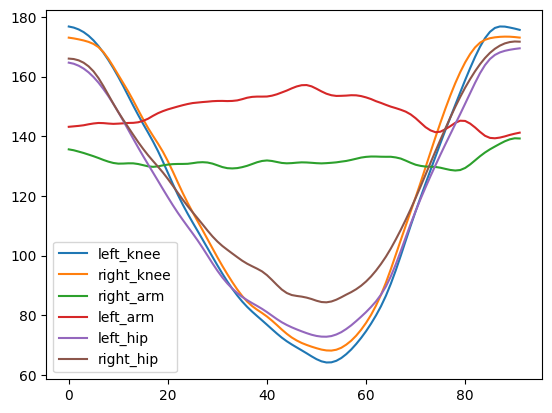

In [7]:
plt.plot(
    batch[0][0, : batch[2][0], :],
    label=[squat_angles_df.columns[i] for i in range(2, 8)],
)
plt.legend()

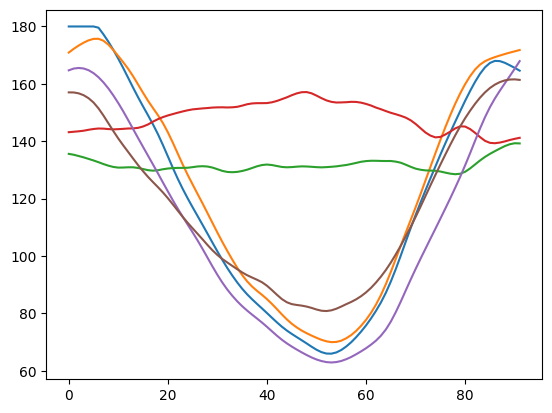

In [8]:
plt.plot(new_sample[:sample_length, :])

In [9]:
sample_min_state = sample.squeeze()[:sample_length].min(dim=0).values
new_sample_min_state = new_sample.min(dim=0).values

In [10]:
print(f"Angles difference between samples: {new_sample_min_state - sample_min_state}")

Angles difference between samples: tensor([ 1.7665,  1.8016,  0.0000,  0.0000, -9.9368, -3.5346])
